In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from matplotlib import colors, ticker
from skimage import measure

from fibrosisanalysis.parsers.stats_loader import StatsLoader
from fibrosisanalysis.slice.heart_slice import HeartSliceBuilder
from fibrosisanalysis.analysis import (
    ObjectsPropertiesBuilder,
    SegmentsPropertiesBuilder
)

from tqdm.notebook import tqdm


def load_slice_data(path, heart, slice_name, subdir, n_angular, n_radial,
                    node_step):
    # Load slice and build HeartSlice object
    heart_slice_builder = HeartSliceBuilder()
    heart_slice_builder.build_from_file(path, heart, slice_name,
                                        n_angular, n_radial, node_step)
    heart_slice = heart_slice_builder.heart_slice

    # Load stats
    path_slice_stats = path.joinpath(heart, subdir, slice_name)
    stats_loader = StatsLoader(path)
    object_stats = stats_loader.load_slice_data(path_slice_stats)

    # Build objects properties
    objects_props_builder = ObjectsPropertiesBuilder()
    objects_props_builder.build_from_stats(object_stats, min_area=1)
    objects_props_builder.add_slice_props(heart_slice)
    df = objects_props_builder.objects_props
    # df['perimeter'] = df['image'].apply(
    #     lambda x: measure.perimeter(x, neighbourhood=4))
    # df['complexity'] = df['perimeter'] ** 2 / (4 * np.pi * df['area'])

    df['location'] = pd.cut(df['segment_labels'],
                            bins=np.linspace(0, n_angular * n_radial,
                                             n_radial + 1),
                            labels=['SUB-ENDO', 'MID', 'SUB-EPI'])
    df['heart'] = heart
    return df.loc[:, ['heart', 'segment_labels',
                      'solidity', 'area', 'location']]


def load_heart_data(heart, path, subdir, n_angular, n_radial, node_step):
    path_ = path.joinpath(heart, 'Stats')
    files = list(path_.glob('*{}'.format('.pkl')))
    files = sorted([file.stem for file in files if not file.name.startswith('.')])
    
    data = []
    for slice_name in tqdm(files):
        df = load_slice_data(path, heart, slice_name, subdir, n_angular, 
                             n_radial, node_step)
        data.append(df)

    return pd.concat(data)


In [2]:
from pathlib import Path
from fibrosisanalysis.parsers import StatsLoader

path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')

hearts = ['E10691_RBM20', 'E11444_LMNA', 'E10927_MYBPC3']
subdir = 'Stats'

stats_loader = StatsLoader(path, subdir='Stats',
                           collected_columns=['area', 'solidity'])
data_or = stats_loader.load_hearts_data(hearts)

stats_loader = StatsLoader(path, subdir='StatsDS',
                           collected_columns=['area', 'solidity'])
data_ds = stats_loader.load_hearts_data(hearts)

stats_loader = StatsLoader(path, subdir='StatsGenerated',
                           collected_columns=['area', 'solidity'])

data_gen = stats_loader.load_hearts_data(hearts)

3/3: 100%|██████████| 15/15 [00:02<00:00,  5.01it/s]


In [3]:
import pandas as pd


data_or['source'] = 'Histological'
data_ds['source'] = 'Direct Sampling'
data_gen['source'] = 'Uniform Generator'

data_all = pd.concat([data_or, data_ds, data_gen]).reset_index(drop=True)

In [4]:
data_all.head()

,area,solidity,Slice,Heart,source
0,6518,0.417633,E10691_16_SC2,E10691_RBM20,Histological
1,2,1.000000,E10691_16_SC2,E10691_RBM20,Histological
2,1,1.000000,E10691_16_SC2,E10691_RBM20,Histological
3,9,0.900000,E10691_16_SC2,E10691_RBM20,Histological
4,3,1.000000,E10691_16_SC2,E10691_RBM20,Histological


In [7]:
from scipy import ndimage as ndi


def quartiles(data):
    res = {}
    area = data['area'].values
    
    index = np.unique(area)

    means = ndi.mean(data['solidity'].values, labels=area, index=index)
    stds = ndi.standard_deviation(data['solidity'].values, labels=area, 
                                  index=index)
    res['area'] = index
    res['mean'] = means
    res['std'] = stds
    return pd.DataFrame(res)


data_grouped = data_all.groupby(['Heart', 'source']).apply(quartiles).reset_index()

/opt/miniconda3/lib/python3.9/site-packages/scipy/ndimage/_measurements.py:523: RuntimeWarning: invalid value encountered in divide
  means = sums / counts
/var/folders/g1/w2ks7h117tx5hyrc51qld9v80000gn/T/ipykernel_2062/2126276533.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_grouped = data_all.groupby(['Heart', 'source']).apply(quartiles).reset_index()


,Heart,source,level_2,area,mean,std
9,E10691_RBM20,Direct Sampling,9,10,0.859116,0.090192
99,E10691_RBM20,Direct Sampling,99,100,0.650683,0.094844
2449,E10691_RBM20,Histological,9,10,0.865324,0.092455
2539,E10691_RBM20,Histological,99,100,0.626700,0.104730
4918,E10691_RBM20,Uniform Generator,9,10,0.734233,0.080400
5008,E10691_RBM20,Uniform Generator,99,100,0.473932,0.059155
5580,E10927_MYBPC3,Direct Sampling,9,10,0.828929,0.091191
5670,E10927_MYBPC3,Direct Sampling,99,100,0.597775,0.093620
7399,E10927_MYBPC3,Histological,9,10,0.833131,0.092553
7489,E10927_MYBPC3,Histological,99,100,0.551828,0.075811


In [7]:
import numpy as np


area_bins = np.geomspace(10, 1e6, 51)

data_all['area_bins'] = pd.cut(data_all['area'], bins=area_bins)

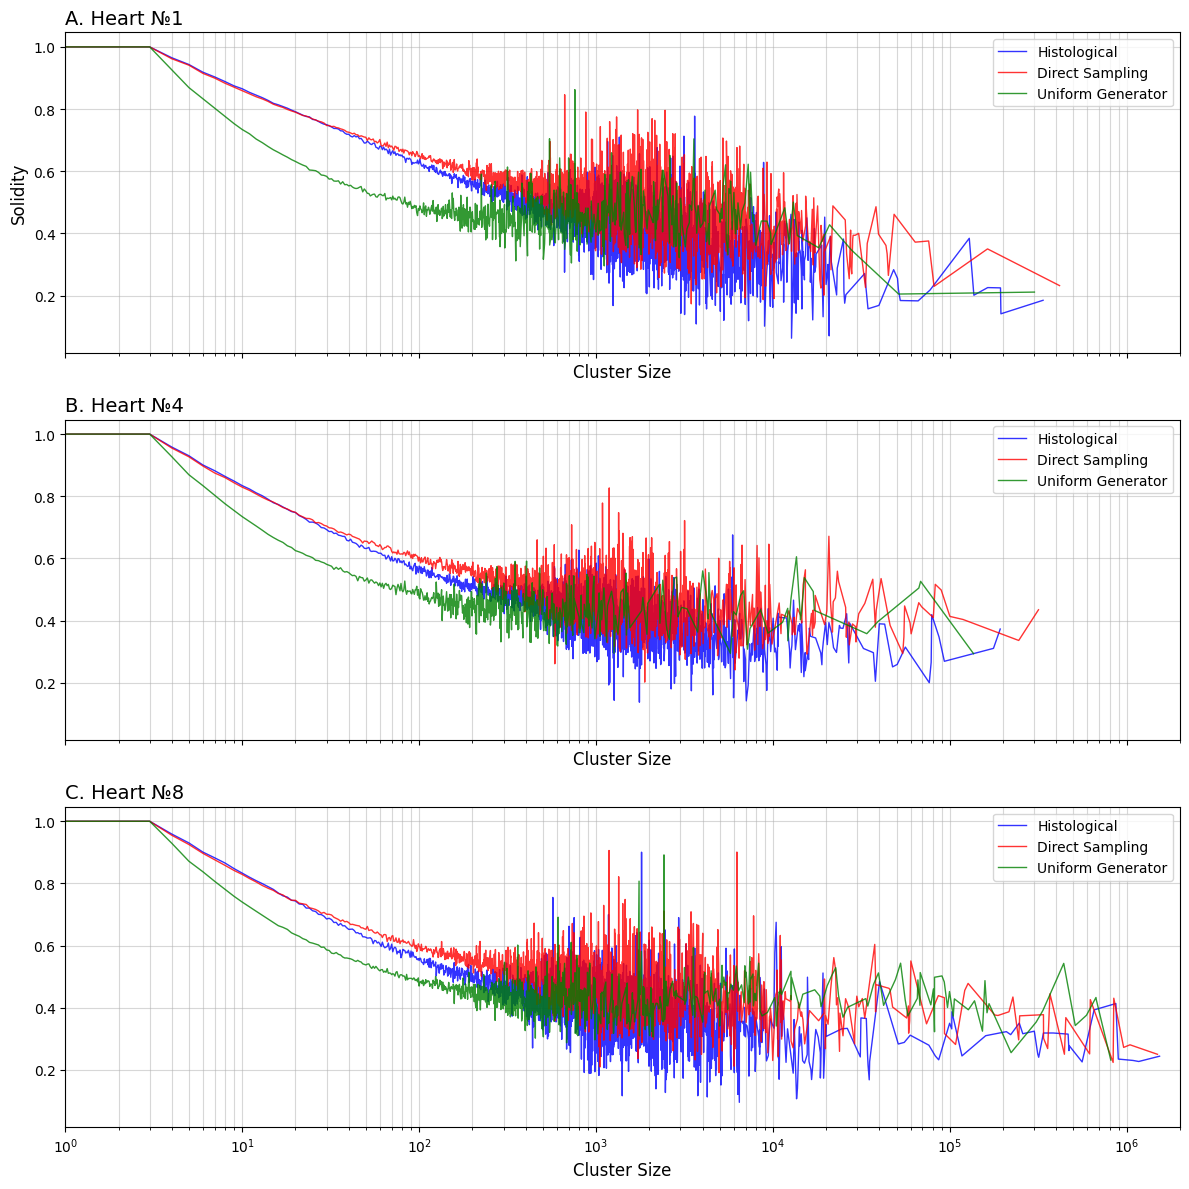

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi


# def quartiles(data):
#     data_stats = data.groupby(['area'], observed=True).describe()

#     print(data_stats)
#     x = data_stats.index
#     medians = data_stats[('solidity', 'mean')]
#     medians.name = 'solidity'
#     std = data_stats[('solidity', 'std')]

#     quartiles1 = medians - std
#     quartiles3 = medians + std

#     # quartiles1 = data_stats[('solidity', '25%')]
#     # quartiles3 = data_stats[('solidity', '75%')]
#     return x, medians.values, quartiles1.values, quartiles3.values

def quartiles(data):
    area = data['area'].values
    
    index = np.unique(area)

    means = ndi.mean(data['solidity'].values, labels=area, index=index)
    stds = ndi.standard_deviation(data['solidity'].values, labels=area, 
                                  index=index)
    minimums = ndi.minimum(data['solidity'].values, labels=area, index=index)
    maximums = ndi.maximum(data['solidity'].values, labels=area, index=index)
    return index, means, minimums, maximums



def plot_quartiles(ax, data, color='blue', label='Histological'):
    area_bins = np.geomspace(10, 1e6, 51)

    # data['area_bins'] = pd.cut(data['area'], bins=area_bins)
    x, medians, quartiles1, quartiles3 = quartiles(data)

    axs[i].plot(x, medians, color=color, label=label, lw=1, alpha=0.8)
    # axs[i].fill_between(x, quartiles1, quartiles3, alpha=0.1,
    #                     color=color)


titles = ['A', 'B', 'C']
heart_labels = [f'Heart №{i}' for i in [1, 4, 8]]
COLORS = {'Histological': 'blue', 'Direct Sampling': 'red',
          'Uniform Generator': 'green'}

fig, axs = plt.subplots(3, 1, figsize=(12, 12), sharex=True, sharey=True)

for i, heart in enumerate(hearts):
    data = data_all[data_all['Heart'] == heart]

    for source in ['Histological', 'Direct Sampling', 'Uniform Generator']:
        data_ = data[data['source'] == source]
        plot_quartiles(axs[i], data_, color=COLORS[source], label=source)

    axs[i].set_title(f'{titles[i]}. {heart_labels[i]}',
                     loc='left', fontsize=14)
    axs[i].legend(loc='upper right', fontsize=10)

for ax in axs:
    ax.set_xscale('log')
    ax.grid(which='both', alpha=0.5)
    ax.set_xlabel('Cluster Size', fontsize=12)
    ax.set_ylabel('Solidity', fontsize=12)
    ax.set_xlim(1, 2e6)
axs[0].set_ylabel('Solidity', fontsize=12)
plt.tight_layout()
plt.show()

In [40]:
path_save = Path('/Users/arstanbek/Projects/FibrosisAnalysis/paperfigures/figures')
fig.savefig(path_save.joinpath('solidity.png'),
            dpi=300, bbox_inches='tight')

In [85]:
df = data[data['area'] < 200]

area_bins = np.arange(df['area'].min(),
                      1 + df['area'].max())
complexity_bins = np.arange(df['complexity'].min(), 
                            1 + df['complexity'].max())


hist, _, _ = np.histogram2d(df['area'], df['complexity'], bins=[area_bins, 
                                                              complexity_bins])
hist = hist.T
hist.shape

(11, 189)

In [92]:
y = (hist / hist.sum(axis=0)[np.newaxis, :])

y = np.cumsum(y[::-1, ::-1], axis=0)[::-1, ::-1]

# y = np.cumsum(np.cumsum(hist[::-1, ::-1], axis=0), axis=1)[::-1, ::-1]
# y = np.where(y == 0, 0, np.log(y))

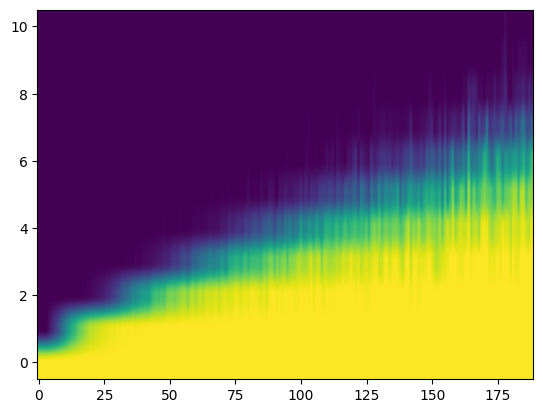

In [93]:
plt.figure()
plt.imshow(y, cmap='viridis', origin='lower', aspect='auto')
plt.show()

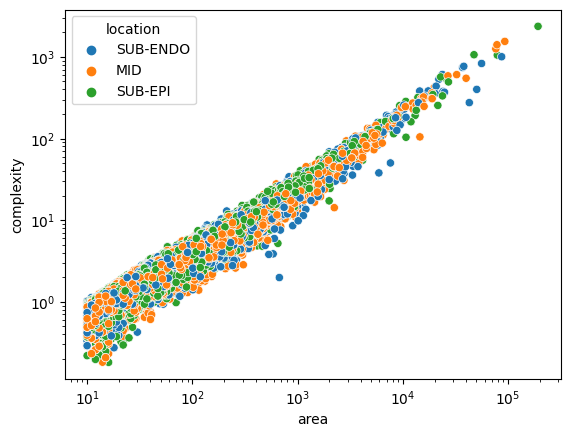

In [30]:
import seaborn as sns


def calc_cdf(df):
    count = np.bincount(df['area'].values, weights=df['complexity'].values)
    area_bins = np.arange(1 + df['area'].max())

    area_bins = area_bins[1:]
    count = count[1:]

    return area_bins, count.cumsum() / count.sum()


plt.figure()
sns.scatterplot(data=data, x='area', y='complexity', hue='location')
plt.xscale('log')
plt.yscale('log')
plt.show()